# AA Tau Veiling from Line Measurements

Quick Links:

* [Theory](#theory)
* Data
    - [Spectra](#spectra)
    - Lines
        - [Optical Lines](#optlines)
        - [Infrared Lines](#irlines)
* [Calculate Extinction from Veiling](#calc)
* [Apply Extinction Correction](#apply)

[Poster Figures](#poster)

In [1]:
# !pip install dust_extinction

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib notebook  
%matplotlib inline 
import astropy
from astropy import units as u
import astropy.table as Table
from astropy.table import QTable
from astropy.io import ascii
from astropy.io import fits
import scipy.interpolate as interp
from synphot import units, config
from synphot import SourceSpectrum,SpectralElement,Observation,ExtinctionModel1D,Empirical1D
from dust_extinction.parameter_averages import CCM89, O94, F99, F04, M14, G16

## Theory Introduction <a name="theory"></a>

Equivalent width is defined as the width of a rectangle with height of the continuum that contains the integrated line flux:



<img src="https://upload.wikimedia.org/wikipedia/commons/2/2e/Definition_of_equivalent_width.jpg">from Wikipedia

In what follows, equivalent width is $EW$, the continuum is $F$, and the integrated line flux is $I$, so that $EW\, F = I$.  If flux is added along the sightline, the additive component raises both the continuum and the line depth by the same amount, so the integrated line flux $I$ is unchanged.  However, the integrated line flux requires a smaller width to represent the same integrated flux for the now-higher continuum, so the equivalent width $EW$ is smaller because of the additive flux component.  

Specifically, *veiling* is "an excess of near-infrared emission with presumably arises from the inner edge of a cool circumstellar disk." (Faesi et al. 2012).  If a stellar flux $F_*$ is veiled by an excess $E$, 
$$
EW_{\rm unveiled} = \frac{I}{F_*}
{\rm \ \ \ and \ \ \ }
EW_{\rm veiled} = \frac{I}{F_*+E}
$$
The integrated line flux $I$ is unchanged by the excess.  

If we define a veiling parameter as 
$$
r_{\lambda} = \frac{E}{F_*}
$$
then with measured equivalent widths,
$$
\frac{EW_{\rm unveiled}}{EW_{\rm veiled}} = \frac{F_*+E}{F_*} = 1 + r_{\lambda}.
$$



If, on ther other hand, there is a multiplicative reduction in stellar flux due to extinction, the situation is reversed. In this case, the flux in the line depth is reduced less than the continuum, and the integrated line intensity is therefore smaller.  The equivalent width, however, remains unchanged.  The ratio of the integrated line itensities before and after extinction is dependent only on the amount of extinction.  If we define an extinction parameter $A$ as
$$
10^{-0.4 A_{\lambda}} = \frac{F_{\rm dusted}}{F_{\rm undusted}}
$$
then with integrated line intensities,
$$
\frac{I_{\rm undusted}}{I_{\rm dusted}} = 10^{+0.4 A_{\lambda}}
$$



Now let's combine both excess, $E$ and extinction, $A$ in the foreground of the star, $F_*$.  What we observe, $O$, is
$$
O = (F_* + E)10^{-0.4 A_{\lambda}}.
$$
Taking the ratio of two observations, with two different excesses and two different extinctions,
$$
\frac{O_{2014}}{O_{2008}} = \frac{F_* + E_{2014}}{F_* + E_{2008}}10^{-0.4 \Delta A_{\lambda}}.
$$

A-ha!  The scaling factor in front of the relative extinction term is just the ratio of the equivalent widths,
$$
\frac{O_{2014}}{O_{2008}} = \frac{EW_{2008}}{EW_{2014}}10^{-0.4 \Delta A_{\lambda}}.
$$
being careful to note the flip in the indices. Notice that the veiling cannot be separated from the extinction.

In other words, to find the extinction from the observed spectra, we need to add a bit in the infrared due to the excess, and we can measure the excess by the ratio of the equivalent widths,
$$
\Delta A_{\lambda} = 2.5 \log\left(\frac{EW_{2008}}{EW_{2014}}\right) + 2.5 \log\left(\frac{O_{2008}}{O_{2014}}\right).
$$

We should mention that this analysis does not allow us to know what the veiling is in either epoch, only the correction needed to calculate an extinction curve. 

## Data

### Spectra (from previous notebook) <a name="spectra"></a>

Read in the spectra:

In [3]:
# from google.colab import files

In [4]:
# upload all txt and tbl files
# uploaded = files.upload()

In [5]:
# for fn in uploaded.keys():
#   print('User uploaded file "{name}" with length {length} bytes'.format(
#       name=fn, length=len(uploaded[fn])))

In [6]:
data1 = ascii.read('AATau_IR2008.txt')
data2 = ascii.read('AATau_opt2008.txt')
data = Table.vstack([data2, data1])
allwav_2008=data['wavelength']
alldata_2008=data['flux']

data1 = ascii.read('AATau_IR2014dec02.txt')
data2 = ascii.read('AATau_opt2014dec02.txt')
data = Table.vstack([data2, data1])
allwav_dec02=data['wavelength']
alldata_dec02=data['flux']

data1 = ascii.read('AATau_IR2014dec12.txt')
data2 = ascii.read('AATau_opt2014dec12.txt')
data = Table.vstack([data2, data1])
allwav_dec12=data['wavelength']
alldata_dec12=data['flux']

Use an interpolation function to be able to divide one spectrum by another.

In [7]:
interp2008=interp.interp1d(allwav_2008,alldata_2008)
ext_dec02=-2.5*np.log10((alldata_dec02/interp2008(allwav_dec02)).value)

C:\Users\krisl\Miniconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


This figure shows a statement of the problem. Simple product of the spectra cannot be represented by an extinction curve.

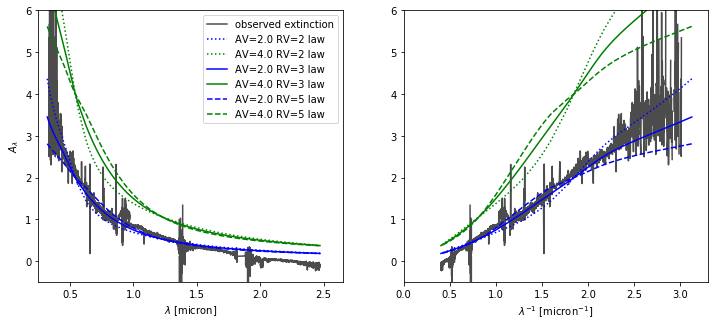

In [8]:
fig,axs=plt.subplots(1,2,figsize=(12,5))

axs[0].plot(allwav_dec02,ext_dec02,'k',alpha=0.7,label='observed extinction')
axs[1].plot(1./allwav_dec02,ext_dec02,'k',alpha=0.7)

for R,line,legend in list(zip((2,3,5),('dotted','solid','dashed'),('2','3','5'))):
    ext=F99(Rv=R)
    axs[0].plot(allwav_2008,2.0*ext(allwav_2008),'b',linestyle=line,label='AV=2.0 RV='+legend+' law')
    axs[1].plot(1/allwav_2008,2.0*ext(allwav_2008),'b',linestyle=line)
    axs[0].plot(allwav_2008,4.0*ext(allwav_2008),'g',linestyle=line,label='AV=4.0 RV='+legend+' law')
    axs[1].plot(1/allwav_2008,4.0*ext(allwav_2008),'g',linestyle=line)

axs[0].legend(loc='best')
axs[0].set_ylabel('$A_\lambda$')
axs[0].set_xlabel('$\lambda$ [micron]')
axs[1].set_xlabel('$\lambda^{-1}$ [micron$^{-1}$]')

axs[0].set_ylim(-0.5,6.0)
axs[1].set_ylim(-0.5,6.0)
axs[0].set_xlim(0.25,2.65)
axs[1].set_xlim(0,3.3)

plt.show()

### Optical Line Measurements <a name="optlines"></a>

In [9]:
t0=Table.Table.read('AA_Tau_espadons.v2.txt',format='ascii')
# I have removed line 62 because it had non numerical values


In [10]:
t0

i,filename[i],MJD,year,mm,dd,i_flux,i_mag,v_mag,snr,mg8807ew,mg_8807_flux,mg8807co,mg_8807_wave,fe8689ew,fe_8689_flux,fe8689co,fe_8689_wave,K7700ew,K_7700_flux,K7700con,K_7700_wave,K7326ew,K_7326_flux,K7326con,K_7326_wave,K7016ew,K_7016_flux,K7016con,K_7016_wave,Li6708ew,Li_6708_flux,Li6708co,Li_6708_wave,bl6500ew,bl_6500_flux,bl6500co,bl_6500_wave,ca6122ew,ca_6122_flux,ca6122co,ca_6122_wave,un5660ew,un_5660_flux,un5660co,un_5660_wave,un5270ew,un_5270_flux,un5270co,un_5270_wave
int32,str13,float64,int32,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0,1046778i.fits,54806.4375,2008,12,6,4.89678,-1.725,12.96,64.0,0.046878,0.00250588,0.053455,880.72998047,0.047765,0.00237585,0.002376,868.90002441,0.055652,0.00224029,0.040255,769.94000244,0.030764,0.00115302,0.03748,732.65002441,0.025526,0.00090923,0.03562,701.66998291,0.05754,0.00173083,0.030081,670.83502197,0.139731,0.0044752,0.032027,649.79998779,0.088331,0.00262717,0.029742,612.25,0.094622,0.00255106,0.026961,566.05999756,0.463586,0.01096113,0.023644,526.84997559
1,1046779i.fits,54806.4531,2008,12,6,5.184492,-1.787,12.9,66.0,0.047739,0.00270865,0.056739,880.72998047,0.049064,0.00258717,0.002587,868.90002441,0.056183,0.00239883,0.042697,769.94000244,0.03079,0.0012229,0.039718,732.65002441,0.025315,0.00095419,0.037692,701.66998291,0.057584,0.00185001,0.032127,670.83502197,0.140187,0.00476801,0.034012,649.79998779,0.088057,0.00278509,0.031628,612.25,0.096342,0.00277375,0.028791,566.05999756,0.464982,0.01173134,0.02523,526.84997559
2,1046780i.fits,54806.4648,2008,12,6,5.079676,-1.765,12.92,65.0,0.047933,0.00267244,0.055754,880.72998047,0.047915,0.00246693,0.002467,868.90002441,0.056334,0.00236965,0.042065,769.94000244,0.031002,0.00120392,0.038833,732.65002441,0.024979,0.0009192,0.036799,701.66998291,0.058499,0.00182013,0.031114,670.83502197,0.138235,0.00456994,0.033059,649.79998779,0.087975,0.00271437,0.030854,612.25,0.09409,0.00264196,0.028079,566.05999756,0.46969,0.01159081,0.024678,526.84997559
3,1046781i.fits,54806.4805,2008,12,6,5.03472,-1.755,12.92,65.0,0.047128,0.00258403,0.054831,880.72998047,0.048851,0.00250422,0.002504,868.90002441,0.055374,0.00228376,0.041242,769.94000244,0.030833,0.00118863,0.03855,732.65002441,0.025675,0.0009432,0.036736,701.66998291,0.05789,0.00179009,0.030922,670.83502197,0.140487,0.00463534,0.032995,649.79998779,0.087189,0.00268225,0.030764,612.25,0.091325,0.00253059,0.02771,566.05999756,0.475531,0.01173403,0.024676,526.84997559
4,1046954i.fits,54807.3867,2008,12,7,5.797891,-1.908,12.77,70.0,0.048199,0.0030353,0.062974,880.72998047,0.049369,0.00291475,0.002915,868.90002441,0.056028,0.00272313,0.048603,769.94000244,0.031155,0.00139653,0.044825,732.65002441,0.026764,0.00115605,0.043195,701.66998291,0.057154,0.00209381,0.036635,670.83502197,0.140445,0.00547055,0.038951,649.79998779,0.088399,0.00323566,0.036603,612.25,0.092091,0.0030517,0.033138,566.05999756,0.462995,0.01355368,0.029274,526.84997559
5,1046955i.fits,54807.4023,2008,12,7,5.824822,-1.913,12.77,70.0,0.049058,0.00312001,0.063598,880.72998047,0.048548,0.00287684,0.002877,868.90002441,0.055524,0.002698,0.048591,769.94000244,0.031371,0.00141586,0.045133,732.65002441,0.026569,0.00114333,0.043033,701.66998291,0.057456,0.00210947,0.036714,670.83502197,0.141697,0.00554518,0.039134,649.79998779,0.08988,0.00331679,0.036903,612.25,0.097386,0.00325545,0.033428,566.05999756,0.472077,0.0138698,0.02938,526.84997559
6,1046956i.fits,54807.418,2008,12,7,5.889675,-1.925,12.75,71.0,0.04937,0.0031712,0.064234,880.72998047,0.048922,0.00292177,0.002922,868.90002441,0.054353,0.0026708,0.049138,769.94000244,0.031032,0.00141065,0.045458,732.65002441,0.026312,0.00114368,0.043467,701.66998291,0.057162,0.00

In [11]:
# Kevin check this out:
# ascii.write(t0, format='latex') 

In [12]:
t0['date']=t0['year']+t0['mm']/12.0+t0['dd']/365.0

In [13]:
ewcols=['mg8807ew','fe8689ew','K7700ew','K7326ew','K7016ew','Li6708ew','bl6500ew','ca6122ew','un5660ew','un5270ew']
contcols=['mg8807co','fe8689co','K7700con','K7326con','K7016con','Li6708co','bl6500co','ca6122co','un5660co','un5270co']
fluxcols=['mg_8807_flux','fe_8689_flux','K_7700_flux','K_7326_flux','K_7016_flux','Li_6708_flux','bl_6500_flux','ca_6122_flux','un_5660_flux','un_5270_flux']
wavecols=['mg_8807_wave','fe_8689_wave','K_7700_wave','K_7326_wave','K_7016_wave','Li_6708_wave','bl_6500_wave','ca_6122_wave','un_5660_wave','un_5270_wave']
fluxcols

['mg_8807_flux',
 'fe_8689_flux',
 'K_7700_flux',
 'K_7326_flux',
 'K_7016_flux',
 'Li_6708_flux',
 'bl_6500_flux',
 'ca_6122_flux',
 'un_5660_flux',
 'un_5270_flux']

Something is wrong here.  The later measurements don't match up.  There isn't enough reddening for this to be real:

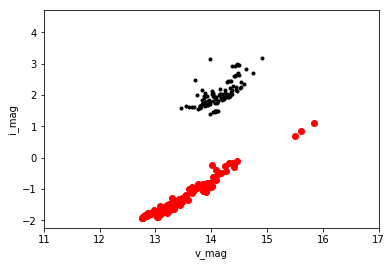

In [14]:
plt.plot(t0['v_mag'][t0['date']<2012],t0['i_mag'][t0['date']<2012],'ro')
plt.plot(t0['v_mag'][t0['date']>2012],t0['i_mag'][t0['date']>2012],'k.')

plt.xlabel('v_mag')
plt.ylabel('i_mag')
plt.xlim(11,17)
plt.show()

Two magnitudes?  Yes.  Four magnitudes?  No

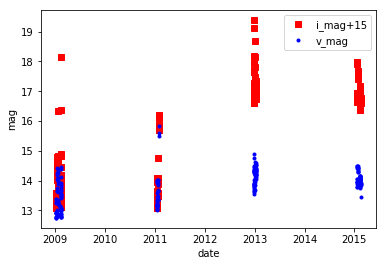

In [15]:
plt.plot(t0['date'],t0['i_mag']+15,'rs',label='i_mag+15')
plt.plot(t0['date'][t0['v_mag']>0],t0['v_mag'][t0['v_mag']>0],'b.',label='v_mag')

plt.xlabel('date')
plt.ylabel('mag')
plt.legend()
plt.show()

And notice that continuua and i_mag scale together, as they must. Date does not separate them, so the error must be an overall scaling factor in the spectra.

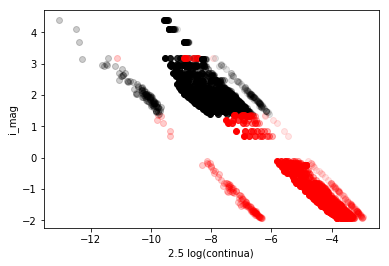

In [16]:
i=0.1
for fx,ew,wav,co in zip(fluxcols,ewcols,wavecols,contcols):
    plt.plot(2.5*np.log10(t0[co][t0['date']<2012]),t0['i_mag'][t0['date']<2012],'ro',label=co,alpha=i)
    plt.plot(2.5*np.log10(t0[co][t0['date']>2012]),t0['i_mag'][t0['date']>2012],'ko',alpha=i)
    i=i+.1
plt.xlabel('2.5 log(continua)')
plt.ylabel('i_mag')
# plt.legend(loc='best')
plt.show()

So, I will look for the >2012 offset:

So, if we assume that the >2012 data needs to be scaled brighter by 2.5 mag, then multiply flux (continuum and integrated line) by $10^{0.4*2.5} = 10$.  Wow, now I really believe that there is an error somewhere in the >2012 data. 

From later on, I will decide on a scale:

In [17]:
espascale=8.0
espamag=2.5*np.log10(espascale)
espascale,espamag

(8.0, 2.257724967479859)

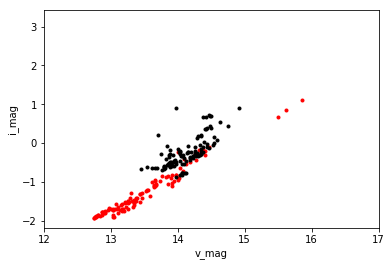

In [18]:
plt.plot(t0['v_mag'][t0['date']<2012],t0['i_mag'][t0['date']<2012],'r.')
plt.plot(t0['v_mag'][t0['date']>2012],t0['i_mag'][t0['date']>2012]-espamag,'k.')
plt.xlabel('v_mag')
plt.ylabel('i_mag')
plt.xlim(12,17)
plt.show()

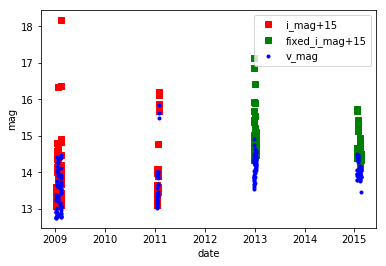

In [19]:
plt.plot(t0['date'][t0['date']<2012],t0['i_mag'][t0['date']<2012]+15,'rs',label='i_mag+15')
plt.plot(t0['date'][t0['date']>2012],t0['i_mag'][t0['date']>2012]+15-espamag,'gs',label='fixed_i_mag+15')
plt.plot(t0['date'][t0['v_mag']>0],t0['v_mag'][t0['v_mag']>0],'b.',label='v_mag')

plt.xlabel('date')
plt.ylabel('mag')
plt.legend()
plt.show()

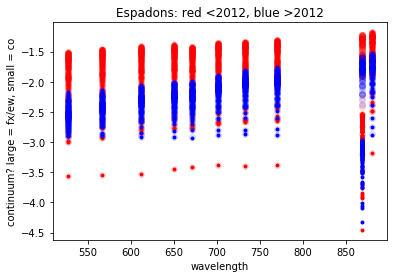

In [20]:
for fx,ew,wav,co in zip(fluxcols,ewcols,wavecols,contcols):
    plt.plot(t0[wav][t0['date']<2012],np.log10((t0[fx]/t0[ew])[t0['date']<2012]),'ro',alpha=0.1)
    plt.plot(t0[wav][t0['date']>2012],np.log10((t0[fx]*espascale/t0[ew])[t0['date']>2012]),'bo',alpha=0.1)
#    mask = (t0['year'] < 2012) & (t0['i_mag'] > -.5)
#    plt.plot(t0[wav][mask],np.log10((t0[fx]/t0[ew])[mask]),'k.')
    plt.plot(t0[wav][t0['date']<2012],np.log10(((t0[co])[t0['date']<2012])),'r.')
    plt.plot(t0[wav][t0['date']>2012],np.log10(((t0[co]*espascale)[t0['date']>2012])),'b.')

# plt.plot(allwav_dec02*1000,np.log10(alldata_dec02.value)+11,'-b',alpha=0.3,label='> 2012')
# plt.plot(allwav_2008*1000,np.log10(alldata_2008.value)+11,'-r',alpha=0.3,label='< 2010')
plt.xlabel('wavelength')
plt.ylabel('continuum? large = fx/ew, small = co')
# plt.ylim(1e-15,1e-12)
plt.title('Espadons: red <2012, blue >2012')
plt.show()

Yes, fx/ew = co but hmm, second to last line is shifted. Again, off by a factor of 10?!.

The EW measurements are fine, of course:

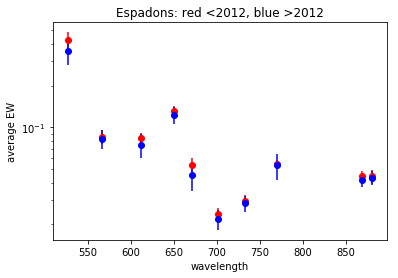

In [21]:
for fx,ew,wav in zip(fluxcols,ewcols,wavecols):
    plt.semilogy(t0[wav][0],np.average(t0[ew][t0['date']<2012]),'ro',label='<2010')
    plt.semilogy(t0[wav][0],np.average(t0[ew][t0['date']>2012]),'bo',label='>2012')
    plt.errorbar(t0[wav][0],np.average(t0[ew][t0['date']<2012]),yerr=np.std(t0[ew][t0['date']<2012]),c='red')
    plt.errorbar(t0[wav][0],np.average(t0[ew][t0['date']>2012]),yerr=np.std(t0[ew][t0['date']>2012]),c='blue')
    plt.xlabel('wavelength')
    plt.ylabel('average EW')
    plt.title('Espadons: red <2012, blue >2012')
    # plt.legend()

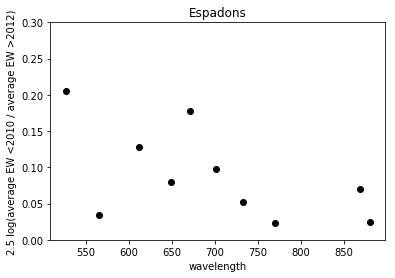

In [22]:
for ew,wav in zip(ewcols,wavecols):
    plt.plot(t0[wav][0],2.5*np.log10(np.average(t0[ew][t0['date']<2012])/np.average(t0[ew][t0['date']>2012])),'ko')
plt.xlabel('wavelength')
plt.ylabel('2.5 log(average EW <2010 / average EW >2012)')
plt.title('Espadons')
plt.ylim(0,0.3)
plt.show()

### Infrared Line Measurements <a name="irlines"></a>

The format of the files is 
date : name : wavelength : EW  : integrated_flux  :   x_blue_continuum : y_blue_continuum : x_red_continuum : y_red continuum

Different attempts may be significantly different line, possible line combinations.  Dates are 2006, 2008, 2012, 2014.92, and 2014.96.

In [23]:
t1=Table.Table.read('EqW_1.txt',format='ascii')
t2=Table.Table.read('EqW_2.txt',format='ascii')
t3=Table.Table.read('EqW_3.txt',format='ascii')

In [24]:
t1

Epoch,LineName,LineLambda,EqW,Flux,blueX,blueY,RedX,RedY
float64,str9,float64,float64,float64,float64,float64,float64,float64
2008.0,Ca-1.03,1.0348,8.317e-05,4.5495e-18,1.0336,5.4944e-14,1.0352,5.4458e-14
2014.92,Ca-1.03,1.0348,7.155e-05,1.8044e-18,1.0338,2.5263e-14,1.0351,2.5175e-14
2014.96,Ca-1.03,1.0348,6.721e-05,1.5121e-18,1.0338,2.2589e-14,1.0351,2.2406e-14
2012.0,Ca-1.03,1.0348,7.0497e-05,1.4029e-17,1.0334,1.9938e-13,1.0349,1.9862e-13
2006.0,Ca-1.03,1.0348,7.3425e-05,5.0339e-18,1.0339,6.8657e-14,1.0355,6.846e-14
2008.0,Si-1.06,1.05888,4.8759e-05,2.6245e-18,1.0582,5.3963e-14,1.0598,5.3689e-14
2014.92,Si-1.06,1.05888,4.6958e-05,1.2007e-18,1.058,2.5507e-14,1.0597,2.5635e-14
2014.96,Si-1.06,1.05888,4.2966e-05,9.6682e-19,1.0583,2.2525e-14,1.0596,2.2479e-14
2012.0,Si-1.06,1.05888,3.7641e-05,7.6887e-18,1.0577,2.0373e-13,1.0596,2.0479e-13


In [25]:
t1['Run']=1
t2['Run']=2
t3['Run']=3

t=Table.vstack([t1,t2,t3])

t2014a=t[t['Epoch']==2014.92]
t2014b=t[t['Epoch']==2014.96]
t2008=t[t['Epoch']==2008]

In [26]:
# Equivalent Width Ratio
EWratio_a=t2008['EqW']/t2014a['EqW']
EWratio_b=t2008['EqW']/t2014b['EqW']

In [27]:
# Integrated line Itensity Ratio
Iratio_a=t2008['Flux']/t2014a['Flux']
Iratio_b=t2008['Flux']/t2014b['Flux']

In [28]:
# From Fischer:
# Fisch_lam=np.array([.48,.51,.55,.59,.63,.67,.74,.81,.86,1.08,.82,.91,.97,1.05,1.18,1.31,1.98,2.11,2.2,2.26])
# Fisch_r=np.array([.1,.1,.1,.1,.1,.1,.1,.1,.1,.1,.1,.2,.2,.2,.2,.2,.3,.3,.3,.5])
# z=np.polyfit(Fisch_lam, Fisch_r, 2)
# print,z

C:\Users\krisl\Miniconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


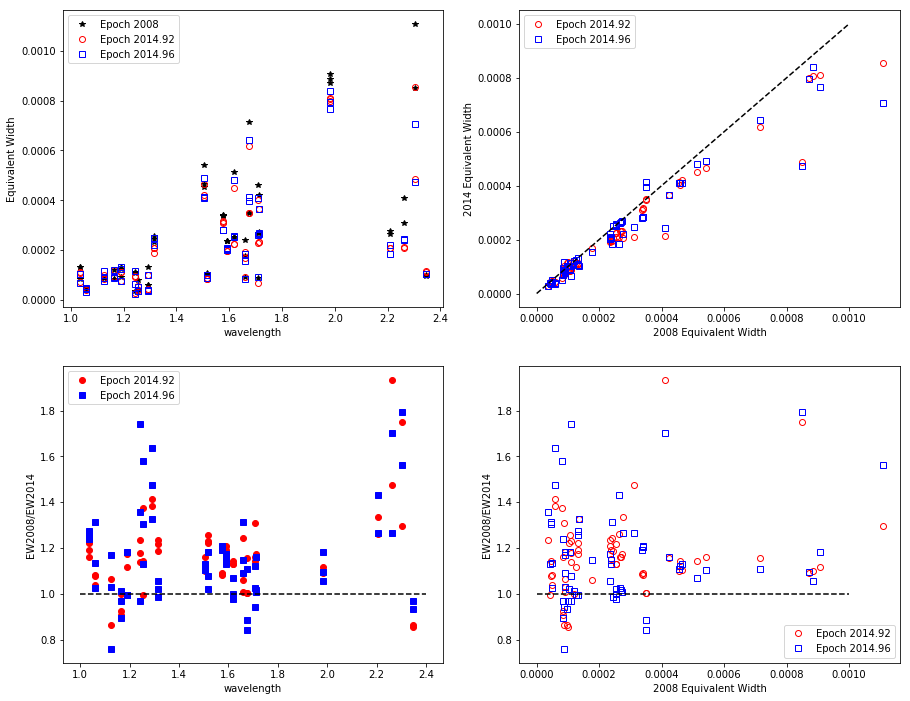

In [29]:
fig,((ax1,ax2),(ax3,ax4))=plt.subplots(2,2,figsize=(15,12))

ax1.plot(t2008['LineLambda'], t2008['EqW'], 'k*', label='Epoch 2008')
ax1.plot(t2008['LineLambda'], t2014a['EqW'], 'ro', fillstyle='none', label='Epoch 2014.92')
ax1.plot(t2008['LineLambda'], t2014b['EqW'], 'bs', fillstyle='none', label='Epoch 2014.96')
ax1.legend()
ax1.set_ylabel('Equivalent Width')
ax1.set_xlabel('wavelength')

ax2.plot(t2008['EqW'], t2014a['EqW'], 'ro', fillstyle='none', label='Epoch 2014.92')
ax2.plot(t2008['EqW'], t2014b['EqW'],  'bs', fillstyle='none', label='Epoch 2014.96')
ax2.legend()
ax2.set_ylabel('2014 Equivalent Width')
ax2.set_xlabel('2008 Equivalent Width')
ax2.plot([0,0.001],[0,0.001],'--k')

ax3.plot(t2008['LineLambda'] ,EWratio_a, 'ro', label='Epoch 2014.92')
ax3.plot(t2008['LineLambda'] ,EWratio_b, 'bs', label='Epoch 2014.96')
ax3.set_xlabel('wavelength')
ax3.set_ylabel('EW2008/EW2014')
ax3.plot([1,2.4],[1,1],'--k')
ax3.legend()

ax4.plot(t2008['EqW'], EWratio_a, 'ro', fillstyle='none', label='Epoch 2014.92')
ax4.plot(t2008['EqW'], EWratio_b, 'bs', fillstyle='none', label='Epoch 2014.96')
ax4.legend(loc="lower right")
ax4.set_ylabel('EW2008/EW2014')
ax4.set_xlabel('2008 Equivalent Width')
ax4.plot([0,0.001],[1,1],'--k')

fig.show()

In [30]:
# Try remaking the lower left plot including which file as symbol shape.
#fig,ax3=plt.subplots(1,1)

#ax3.plot(t2008['LineLambda'][t2008['Run']==1] ,r2014a[t2008['Run']==1], 'rs', fillstyle='none',label='2014.92 #1')
#ax3.plot(t2008['LineLambda'][t2008['Run']==2] ,r2014a[t2008['Run']==2], 'ro', fillstyle='none',label='2014.92 #2')
#ax3.plot(t2008['LineLambda'][t2008['Run']==3] ,r2014a[t2008['Run']==3], 'r^', fillstyle='none',label='2014.92 #3')

#ax3.plot(t2008['LineLambda'][t2008['Run']==1] ,r2014b[t2008['Run']==1], 'bs', fillstyle='none',label='2014.96 #1')
#ax3.plot(t2008['LineLambda'][t2008['Run']==2] ,r2014b[t2008['Run']==2], 'bo', fillstyle='none',label='2014.96 #2')
#ax3.plot(t2008['LineLambda'][t2008['Run']==3] ,r2014b[t2008['Run']==3], 'b^', fillstyle='none',label='2014.96 #3')
#ax3.set_xlabel('wavelength')
#ax3.set_ylabel('$r_\lambda$ relative to 2008')
#ax3.plot([1,2.4],[0,0],'--k')
#ax3.legend()

#plt.show()   

Some lines are clearly better than others.  Let's get a list of unique line names, then make a separate plot by line.

In [31]:
uniquelines=Table.unique(t2008,keys="LineName")['LineName','LineLambda']
uniquelines.sort('LineLambda')
uniquelines

LineName,LineLambda
str9,float64
Ca-1.03,1.0348
Si-1.06,1.05888
Al-1.12,1.1258
Fe-1.17,1.1645
Fe-1.19,1.1887
K-1.24,1.24368
K-1.25,1.2526
Mn-1.29,1.29045
Al-1.31,1.3141


In [32]:
# and sort by wavelength
lines=uniquelines['LineName']
lines

Ca-1.03
Si-1.06
Al-1.12
Fe-1.17
Fe-1.19
K-1.24
K-1.25
Mn-1.29
Al-1.31
Mg-1.50
KI-1.51


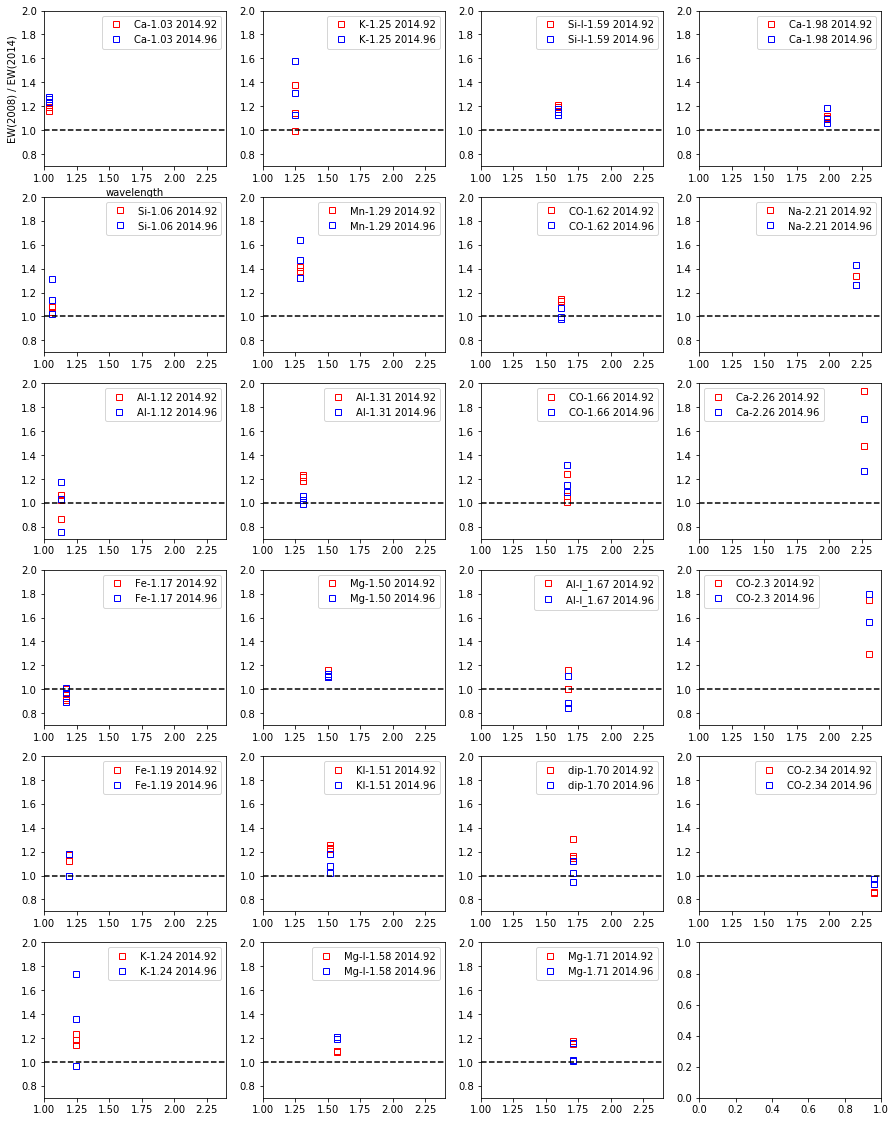

In [33]:
fig,axs=plt.subplots(6,4,figsize=(15,20))

for j in range(4):

    for i in range(6):

        if (i+j*6<23):
            
            axs[i,j].plot(t2008['LineLambda'][t2008['LineName']==lines[i+j*6]],EWratio_a[t2008['LineName']==lines[i+j*6]],
                          'rs',fillstyle='none',label=lines[i+j*6]+' 2014.92')
            axs[i,j].plot(t2008['LineLambda'][t2008['LineName']==lines[i+j*6]],EWratio_b[t2008['LineName']==lines[i+j*6]],
                          'bs',fillstyle='none',label=lines[i+j*6]+' 2014.96')
            axs[i,j].set_xlim(1,2.4)
            axs[i,j].set_ylim(0.7,2.0)
            axs[i,j].plot([1,2.4],[1,1],'--k')
            axs[i,j].legend()

axs[0,0].set_ylabel('EW(2008) / EW(2014)')
axs[0,0].set_xlabel('wavelength')

plt.show()

## Calculate Extinction from Veiling <a name="calc"></a>

In [34]:
za=np.polyfit(np.log10(t2014a['LineLambda']) , np.log10(EWratio_a), 1)
zb=np.polyfit(np.log10(t2014b['LineLambda']) , np.log10(EWratio_b), 1)

[]

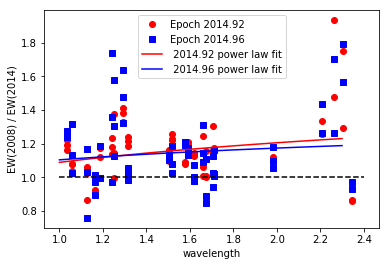

In [35]:
plt.plot(t2014a['LineLambda'], EWratio_a, 'ro', label='Epoch 2014.92')
plt.plot(t2014b['LineLambda'], EWratio_b, 'bs', label='Epoch 2014.96')

x=np.arange(1,2.4,.1)
plt.plot(x, 10**(za[1]) * x**(za[0]),'r',label=' 2014.92 power law fit')
plt.plot(x, 10**(zb[1]) * x**(zb[0]),'b',label=' 2014.96 power law fit')

plt.xlabel('wavelength')
plt.ylabel('EW(2008) / EW(2014)')
plt.plot([1,2.4],[1,1],'--k')
plt.legend()
plt.plot()

Better: take the log, since that is what we are going to do anyway!

In [36]:
za=np.polyfit(t2014a['LineLambda'] , 2.5*np.log10(EWratio_a), 1)
zb=np.polyfit(t2014b['LineLambda'] , 2.5*np.log10(EWratio_b), 1)
za, zb

(array([ 0.1024886, -0.0013032]), array([0.0756611 , 0.02939213]))

[]

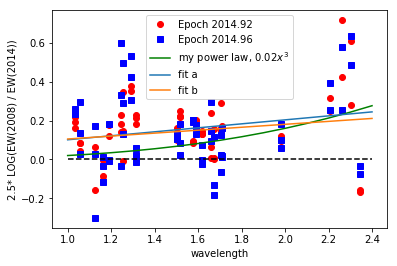

In [37]:
plt.plot(t2014a['LineLambda'], 2.5*np.log10(EWratio_a), 'ro', label='Epoch 2014.92')
plt.plot(t2014b['LineLambda'], 2.5*np.log10(EWratio_b), 'bs', label='Epoch 2014.96')

x=np.arange(1,2.5,.1)
plt.plot(x,0.02*x**3,'-g',label='my power law, $0.02 x^3$')
plt.plot(x,za[1]+za[0]*x,label='fit a')
plt.plot(x,zb[1]+zb[0]*x,label='fit b')

plt.xlabel('wavelength')
plt.ylabel('2.5* LOG(EW(2008) / EW(2014))')
plt.plot([1,2.4],[0,0],'--k')
plt.legend()
plt.plot()

And try averaging over each line:

[]

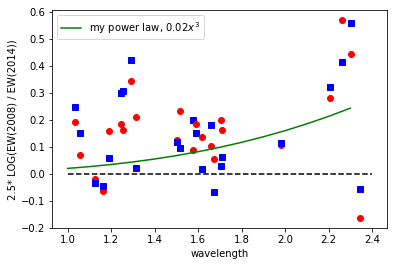

In [38]:
for line in lines:
    plt.plot(np.mean(t2014a['LineLambda'][t2014a['LineName']==line]), np.mean(2.5*np.log10(EWratio_a)[t2014a['LineName']==line]), 'ro')
    plt.plot(np.mean(t2014b['LineLambda'][t2014a['LineName']==line]), np.mean(2.5*np.log10(EWratio_b)[t2014a['LineName']==line]), 'bs')

x=np.arange(1,2.4,.1)
plt.plot(x,0.02*x**3,'-g',label='my power law, $0.02 x^3$')

plt.xlabel('wavelength')
plt.ylabel('2.5* LOG(EW(2008) / EW(2014))')
plt.plot([1,2.4],[0,0],'--k')
plt.legend()
plt.plot()

Now include the optical lines, too:

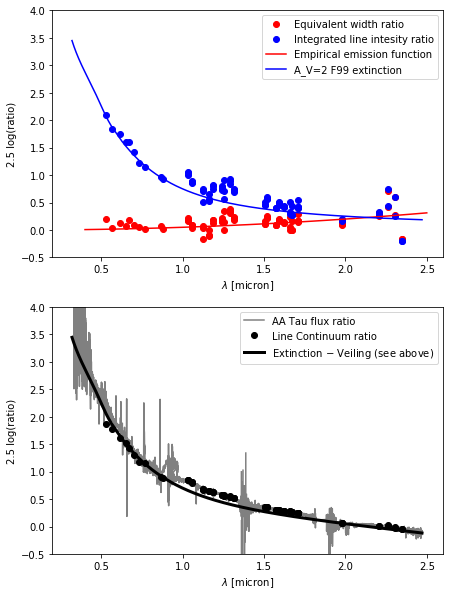

In [39]:
fig,(ax1,ax2)=plt.subplots(2,1,figsize=[7,10])
ax1.plot(t2014a['LineLambda'],2.5*np.log10(EWratio_a),'ro',label='Equivalent width ratio')
ax1.plot(t2014a['LineLambda'],2.5*np.log10(Iratio_a),'bo',label='Integrated line intesity ratio')
# ax.plot(t2014a['LineLambda'],2.5*np.log10(EWratio_b),'ro')
# ax.plot(t2014a['LineLambda'],2.5*np.log10(Iratio_b),'bo')

x=np.arange(0.4,2.6,.1)
ax1.plot(x,0.05*x**2,'-r',label='Empirical emission function')
# FM04 Al/EBV = 0.63R - 0.83)lambda^-1.84
# So, Al/AV = 0.63 - 0.83/R)lambda^-1.84 -> Al = 0.35lambda^-1.84 per AV
# ax1.plot(x,1.0*x**-1.84,'-b',label='NIR extinction law, $1.0 x^{-1.84}$')

ax2.plot(allwav_dec02,ext_dec02,'grey',label='AA Tau flux ratio')
ax2.plot(t2014a['LineLambda'],2.5*np.log10(Iratio_a/EWratio_a),'o',color='black',label='Line Continuum ratio')

# NEW!  Optical Lines
for fx,ew,wav in zip(fluxcols,ewcols,wavecols):
    ax1.plot(t0[wav][0]/1000,2.5*np.log10(np.average(t0[ew][t0['date']<2012])
                                          /np.average(t0[ew][t0['date']>2012])),'ro')
    ax1.plot(t0[wav][0]/1000,2.5*np.log10(np.average(t0[fx][t0['date']<2012])
                                          /np.average(espascale*t0[fx][t0['date']>2012])),'bo')
    ax2.plot(t0[wav][0]/1000,2.5*np.log10(np.average((t0[fx]/t0[ew])[t0['date']<2012])
                                    /np.average((espascale*t0[fx]/t0[ew])[t0['date']>2012])),'ko')

ext=F99(Rv=3)
ax1.plot(allwav_2008,2.0*ext(allwav_2008),'b',label='A_V=2 F99 extinction')
ax2.plot(allwav_2008,2.0*ext(allwav_2008)-0.05*allwav_2008.value**2,'k',label='Extinction $-$ Veiling (see above)',linewidth=3)
    
ax1.set_xlim(0.2,2.6)
ax1.set_ylim(-.5,4)
ax1.set_xlabel('$\lambda$ [micron]')
ax1.set_ylabel('2.5 log(ratio)')
ax1.legend(loc='upper right')

ax2.set_xlim(0.2,2.6)
ax2.set_ylim(-.5,4)
ax2.set_xlabel('$\lambda$ [micron]')
ax2.set_ylabel('2.5 log(ratio)')
ax2.legend(loc='best')

plt.show()

## Apply Extinction Correction <a name="apply"></a>

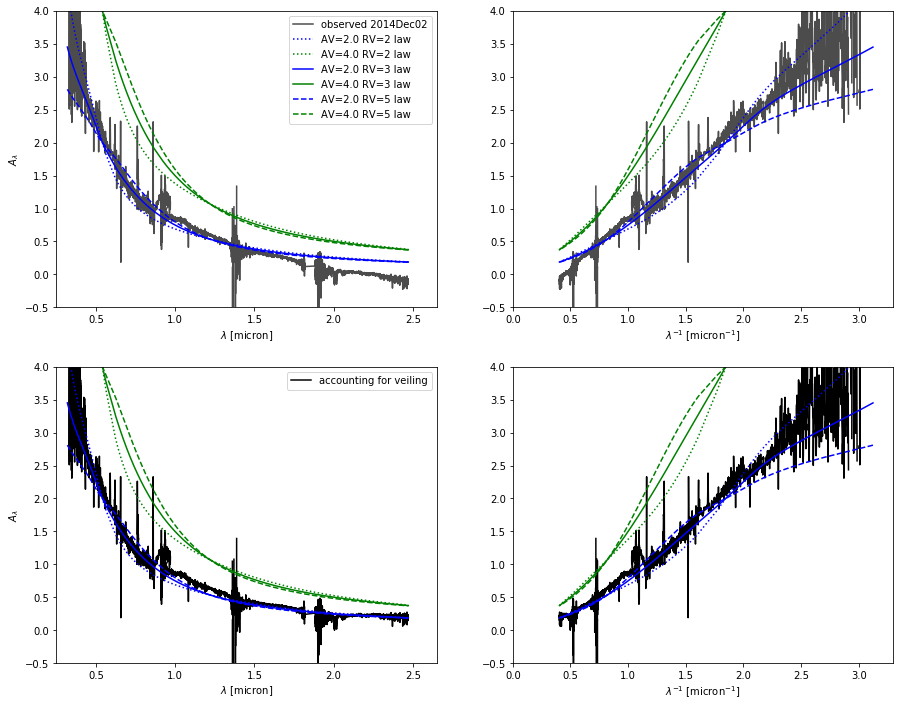

In [40]:
fig,axs=plt.subplots(2,2,figsize=(15,12))

axs[0,0].plot(allwav_dec02,ext_dec02,'k',alpha=0.7,label='observed 2014Dec02')
axs[0,1].plot(1./allwav_dec02,ext_dec02,'k',alpha=0.7)

for R,line,legend in list(zip((2,3,5),('dotted','solid','dashed'),('2','3','5'))):
    ext=F99(Rv=R)
    axs[0,0].plot(allwav_2008,2.0*ext(allwav_2008),'b',linestyle=line,label='AV=2.0 RV='+legend+' law')
    axs[0,1].plot(1/allwav_2008,2.0*ext(allwav_2008),'b',linestyle=line)
    axs[0,0].plot(allwav_2008,4.0*ext(allwav_2008),'g',linestyle=line,label='AV=4.0 RV='+legend+' law')
    axs[0,1].plot(1/allwav_2008,4.0*ext(allwav_2008),'g',linestyle=line)

axs[0,0].legend(loc='best')
axs[0,0].set_ylabel('$A_\lambda$')
axs[0,0].set_xlabel('$\lambda$ [micron]')
axs[0,1].set_xlabel('$\lambda^{-1}$ [micron$^{-1}$]')

axs[0,0].set_ylim(-0.5,4.0)
axs[0,1].set_ylim(-0.5,4.0)
axs[0,0].set_xlim(0.25,2.65)
axs[0,1].set_xlim(0,3.3)

# now with veiling

axs[1,0].plot(allwav_dec02,ext_dec02+0.02*allwav_dec02.value**3,'k',label='accounting for veiling')
axs[1,1].plot(1./allwav_dec02,ext_dec02+0.02*allwav_dec02.value**3,'k')

for R,line,legend in list(zip((2,3,5),('dotted','solid','dashed'),('2','3','5'))):
    ext=F99(Rv=R)
    axs[1,0].plot(allwav_2008,2.0*ext(allwav_2008),'b',linestyle=line)
    axs[1,1].plot(1/allwav_2008,2.0*ext(allwav_2008),'b',linestyle=line)
    axs[1,0].plot(allwav_2008,4.0*ext(allwav_2008),'g',linestyle=line)
    axs[1,1].plot(1/allwav_2008,4.0*ext(allwav_2008),'g',linestyle=line)

axs[1,0].legend(loc='best')
axs[1,0].set_ylabel('$A_\lambda$')
axs[1,0].set_xlabel('$\lambda$ [micron]')
axs[1,1].set_xlabel('$\lambda^{-1}$ [micron$^{-1}$]')

axs[1,0].set_ylim(-0.5,4.0)
axs[1,1].set_ylim(-0.5,4.0)
axs[1,0].set_xlim(0.25,2.65)
axs[1,1].set_xlim(0,3.3)

plt.show()

Woot!

Can we check our analysis?   $EW\, F = I$ so (EWratio)(Observed flux ratio) = (Line intensity ratio).  So,  

This makes sense.  The blue is the line intensity ratio, which traces extinction, and it decreases with wavelength as we expect.  The red is the EW ratio, which traces veiling, and it increases slightly with wavelength as we expect.

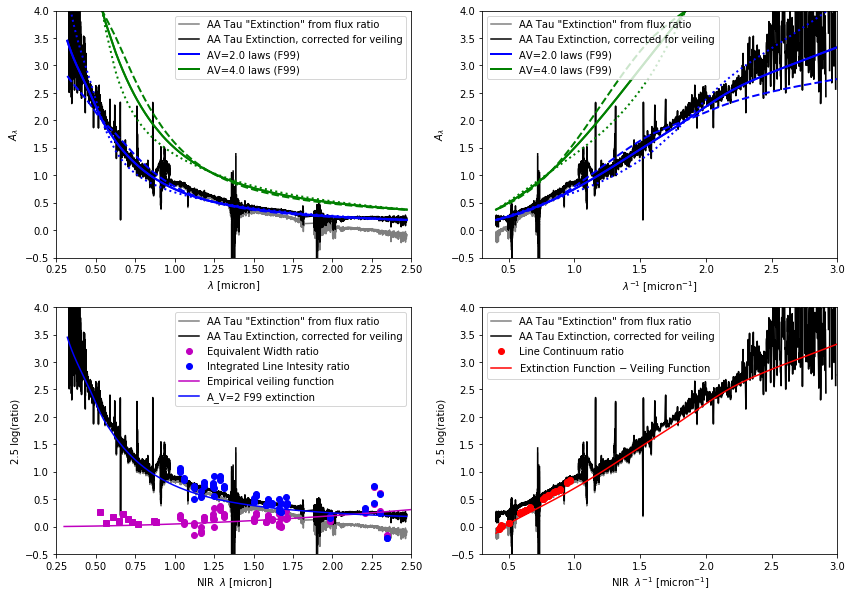

In [41]:
fig2,axs2=plt.subplots(2,2,figsize=(14,10))

axs2[0,0].plot(allwav_dec02,ext_dec02,'k',alpha=0.5,label='AA Tau "Extinction" from flux ratio')
axs2[0,1].plot(1./allwav_dec02,ext_dec02,'k',alpha=0.5,label='AA Tau "Extinction" from flux ratio')

# now with veiling

axs2[0,0].plot(allwav_dec02,ext_dec02+0.02*allwav_dec02.value**3,'k',label='AA Tau Extinction, corrected for veiling')
axs2[0,1].plot(1./allwav_dec02,ext_dec02+0.02*allwav_dec02.value**3,'k',label='AA Tau Extinction, corrected for veiling')

for R,line,legend in list(zip((2,3,5),('dotted','solid','dashed'),('2','3','5'))):
    ext=F99(Rv=R)
    axs2[0,0].plot(allwav_2008,2.0*ext(allwav_2008),'b',linestyle=line,linewidth=2)
    axs2[0,1].plot(1/allwav_2008,2.0*ext(allwav_2008),'b',linestyle=line,linewidth=2)
    axs2[0,0].plot(allwav_2008,4.0*ext(allwav_2008),'g',linestyle=line,linewidth=2)
    axs2[0,1].plot(1/allwav_2008,4.0*ext(allwav_2008),'g',linestyle=line,linewidth=2)

ext=F99(Rv=3)
axs2[0,0].plot(allwav_2008,2.0*ext(allwav_2008),'b',linestyle='solid',linewidth=2,label='AV=2.0 laws (F99)')
axs2[0,0].plot(allwav_2008,4.0*ext(allwav_2008),'g',linestyle='solid',linewidth=2,label='AV=4.0 laws (F99)')
axs2[0,1].plot(1/allwav_2008,2.0*ext(allwav_2008),'b',linestyle='solid',linewidth=2,label='AV=2.0 laws (F99)')
axs2[0,1].plot(1/allwav_2008,4.0*ext(allwav_2008),'g',linestyle='solid',linewidth=2,label='AV=4.0 laws (F99)')

# for line in lines:
#     xx=np.mean(t2014a['LineLambda'][t2014a['LineName']==line])
#     yy=0.5*(np.mean(2.5*np.log10(Iratio_a)[t2014a['LineName']==line])+np.mean(2.5*np.log10(Iratio_b)[t2014a['LineName']==line]))
#     axs[0,0].plot(xx,yy, 'ro')
#     axs[1,0].plot(xx,yy, 'ro')
#     axs[0,1].plot(1/xx,yy, 'ro')
#     axs[1,1].plot(1/xx,yy, 'ro')
# axs[0,0].plot(xx,yy, 'ro', label='from line flux ratio',fillstyle='none')

# BOTTOM PANEL

axs2[1,0].plot(allwav_dec02,ext_dec02,'k',alpha=0.5,label='AA Tau "Extinction" from flux ratio')
axs2[1,0].plot(allwav_dec02,ext_dec02+0.05*allwav_dec02.value**2,'k',label='AA Tau Extinction, corrected for veiling')
axs2[1,0].plot(t2014a['LineLambda'],2.5*np.log10(EWratio_a),'mo',label='Equivalent Width ratio')
axs2[1,0].plot(t2014a['LineLambda'],2.5*np.log10(Iratio_a),'bo',label='Integrated Line Intesity ratio')

# NEW!  Optical Lines
for ew,wav in zip(ewcols,wavecols):
    axs2[1,0].plot(t0[wav][0]/1000,2.5*np.log10(np.average(t0[ew][t0['date']<2010])
                                          /np.average(t0[ew][t0['date']>2012])),'ms')
      
x=np.arange(0.3,2.6,.1)
axs2[1,0].plot(x,0.05*x**2,'-m',label='Empirical veiling function')
# FM04 Al/EBV = 0.63R - 0.83)lambda^-1.84
# So, Al/AV = 0.63 - 0.83/R)lambda^-1.84 -> Al = 0.35lambda^-1.84 per AV
axs2[1,0].plot(allwav_2008,2.0*ext(allwav_2008),'b',label='A_V=2 F99 extinction')
# axs2[1,0].plot(x,1.0*x**-1.84,'-b',label='NIR extinction law, $1.0 x^{-1.84}$')

axs2[1,1].plot(1/allwav_dec02,ext_dec02,'k',alpha=0.5,label='AA Tau "Extinction" from flux ratio')
axs2[1,1].plot(1./allwav_dec02,ext_dec02+0.05*allwav_dec02.value**2,'k',label='AA Tau Extinction, corrected for veiling')
axs2[1,1].plot(1/t2014a['LineLambda'],2.5*np.log10(Iratio_a/EWratio_a),'o',color='r',label='Line Continuum ratio')
axs2[1,1].plot(1./allwav_dec02,2.0*ext(allwav_dec02)  -  0.05*allwav_dec02.value**2.0,'r',label='Extinction Function $-$ Veiling Function')

axs2[0,0].set_ylim(-0.5,4.0)
axs2[0,0].set_xlim(0.25,2.5)
axs2[0,0].set_ylabel('$A_\lambda$')
axs2[0,0].set_xlabel('$\lambda$ [micron]')
axs2[0,0].legend(loc='upper right')

axs2[0,1].set_ylim(-0.5,4.0)
axs2[0,1].set_xlim(0.3,3.0)
axs2[0,1].set_ylabel('$A_\lambda$')
axs2[0,1].set_xlabel('$\lambda^{-1}$ [micron$^{-1}$]')
axs2[0,1].legend(loc='upper left')

axs2[1,0].set_ylim(-0.5,4.0)
axs2[1,0].set_xlim(0.25,2.5)
axs2[1,0].set_xlabel('NIR  $\lambda$ [micron]')
axs2[1,0].set_ylabel('2.5 log(ratio)')
axs2[1,0].legend(loc='upper right')

axs2[1,1].set_ylim(-0.5,4.0)
axs2[1,1].set_xlim(0.3,3.0)
axs2[1,1].set_xlabel('NIR  $\lambda^{-1}$ [micron$^{-1}$]')
axs2[1,1].set_ylabel('2.5 log(ratio)')
axs2[1,1].legend(loc="upper left")

## POSTER FIGURES <a name="poster"></a>


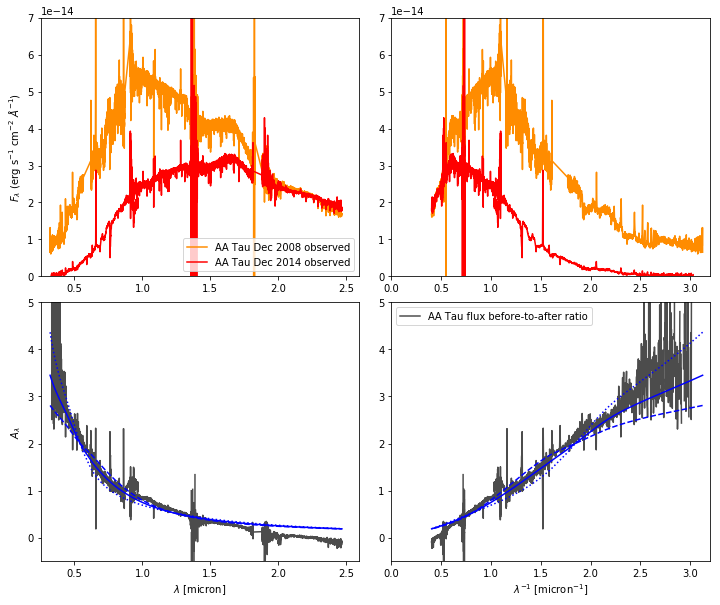

In [42]:
fig,axs=plt.subplots(2,2,figsize=(12,10))

axs[0,0].plot(allwav_2008,alldata_2008,'darkorange',label='AA Tau Dec 2008 observed')
axs[0,0].plot(allwav_dec02,alldata_dec02,'red',label='AA Tau Dec 2014 observed')
axs[0,1].plot(1/allwav_2008,alldata_2008,'darkorange')
axs[0,1].plot(1/allwav_dec02,alldata_dec02,'red')

axs[0,0].set_xlim(0.25,2.6)
axs[0,0].set_ylim(0,0.7E-13)
axs[0,0].set_ylabel('$F_\lambda$ (erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$)')
axs[0,0].legend(loc='best')
axs[0,1].set_xlim(0,3.2)
axs[0,1].set_ylim(0,0.7E-13)

axs[1,0].plot(allwav_dec02,ext_dec02,'k',alpha=0.7)
axs[1,1].plot(1./allwav_dec02,ext_dec02,'k',alpha=0.7,label='AA Tau flux before-to-after ratio')

for Rv,line in list(zip((2,3,5),('dotted','solid','dashed'))):
    ext=F99(Rv=Rv)
    axs[1,0].plot(allwav_2008,2.0*ext(1/allwav_2008.value),'blue',linestyle=line)
    axs[1,1].plot(1/allwav_2008,2.0*ext(1/allwav_2008.value),'blue',linestyle=line)
#    ext=CCM89(Rv=Rv)
#    axs[1,0].plot(allwav_2008,2.0*ext(allwav_2008*u.micron),'blue',linestyle=line)
#    axs[1,1].plot(1/allwav_2008,2.0*ext(allwav_2008*u.micron),'blue',linestyle=line)
#    ext=F04(Rv=Rv)
#    axs[1,0].plot(allwav_2008,2.0*ext(allwav_2008*u.micron),'blue',linestyle=line)
#    axs[1,1].plot(1/allwav_2008,2.0*ext(allwav_2008*u.micron),'blue',linestyle=line)
#    ext=M14(Rv=Rv)
#    axs[1,0].plot(allwav_2008,2.0*ext(allwav_2008*u.micron),'blue',linestyle=line)
#    axs[1,1].plot(1/allwav_2008,2.0*ext(allwav_2008*u.micron),'blue',linestyle=line)
#    ext=G16(RvA=Rv, fA=1.0)
#    axs[1,0].plot(allwav_2008,2.0*ext(allwav_2008*u.micron),'blue',linestyle=line)
#    axs[1,1].plot(1/allwav_2008,2.0*ext(allwav_2008*u.micron),'blue',linestyle=line)

# axs[1,0].plot(allwav_2008,4.0*ext(allwav_2008*u.micron),'green',linewidth=3,label='AV=4.0 RV=3 law (F99)')
# axs[1,1].plot(1/allwav_2008,4.0*ext(allwav_2008*u.micron),'green',linewidth=3)

ext=F99(Rv=3)
# axs[1,1].plot([0,1/allwav_2008[-1]],[0,2.0*ext(allwav_2008[-1])],
#               'blue',linestyle='solid',label='various AV=2 extinction laws')

axs[1,1].legend(loc='best')
axs[1,0].set_ylabel('$A_\lambda$')
axs[1,0].set_xlabel('$\lambda$ [micron]')
axs[1,1].set_xlabel('$\lambda^{-1}$ [micron$^{-1}$]')

axs[1,0].set_ylim(-0.5,5.0)
axs[1,1].set_ylim(-0.5,5.0)
axs[1,0].set_xlim(0.25,2.6)
axs[1,1].set_xlim(0,3.2)

fig.subplots_adjust(hspace=0.1)
fig.subplots_adjust(wspace=0.1)

plt.show()

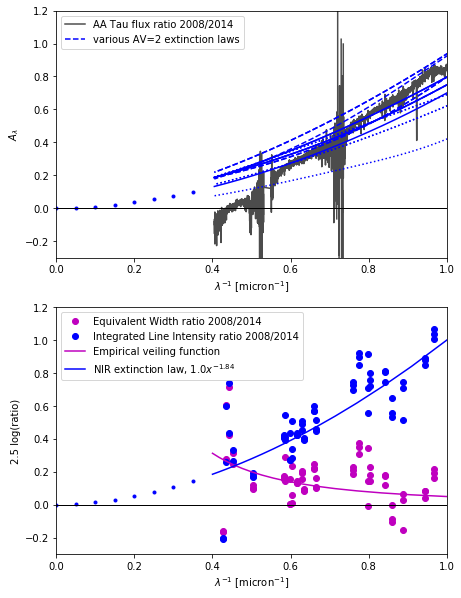

In [43]:
fig,(ax1,ax2)=plt.subplots(2,1,figsize=[7,10])

ax1.plot(1./allwav_dec02,ext_dec02,'k',alpha=0.7,label='AA Tau flux ratio 2008/2014')

for Rv,line in list(zip((2,3,5),('dotted','solid','dashed'))):
    ext=F99(Rv=Rv)
    ax1.plot(1/allwav_2008,2.0*ext(allwav_2008),'blue',linestyle=line)
    ext=CCM89(Rv=Rv)
    ax1.plot(1/allwav_2008,2.0*ext(allwav_2008),'blue',linestyle=line)
    ext=F04(Rv=Rv)
    ax1.plot(1/allwav_2008,2.0*ext(allwav_2008),'blue',linestyle=line)
    ext=M14(Rv=Rv)
    ax1.plot(1/allwav_2008,2.0*ext(allwav_2008),'blue',linestyle=line)
    ext=G16(RvA=Rv, fA=1.0)
    ax1.plot(1/allwav_2008,2.0*ext(allwav_2008),'blue',linestyle=line)

ext=F99(Rv=3)
ax1.plot(1/allwav_2008,2.0*ext(allwav_2008),'blue',linestyle=line,label='various AV=2 extinction laws')

x=np.arange(0,0.4,.05)
ax1.plot(x,0.7*x**1.84,'b.')

ax1.legend(loc='upper left')
ax1.set_ylabel('$A_\lambda$')
ax1.set_xlabel('$\lambda^{-1}$ [micron$^{-1}$]')
ax1.set_ylim(-0.3,1.2)
ax1.set_xlim(0,1)

ax2.plot(1/t2014a['LineLambda'],2.5*np.log10(EWratio_a),'mo',label='Equivalent Width ratio 2008/2014')
ax2.plot(1/t2014a['LineLambda'],2.5*np.log10(Iratio_a),'bo',label='Integrated Line Intensity ratio 2008/2014')

x=np.arange(1,2.6,.1)
ax2.plot(1/x,0.05*x**2,'-m',label='Empirical veiling function')
# FM04 Al/EBV = 0.63R - 0.83)lambda^-1.84
# So, Al/AV = 0.63 - 0.83/R)lambda^-1.84 -> Al = 0.35lambda^-1.84 per AV
ax2.plot(1/x,1.0*x**-1.84,'-b',label='NIR extinction law, $1.0 x^{-1.84}$')

x=np.arange(0,0.4,.05)
ax2.plot(x,1.0*x**1.84,'b.')

ax2.set_xlim(0,1)
ax2.set_ylim(-0.3,1.2)
ax2.set_xlabel('$\lambda^{-1}$ [micron$^{-1}$]')
ax2.set_ylabel('2.5 log(ratio)')
ax2.legend(loc='upper left')

ax1.plot([0,2],[0,0],'k',linewidth=1)
ax2.plot([0,2],[0,0],'k',linewidth=1)

plt.show()

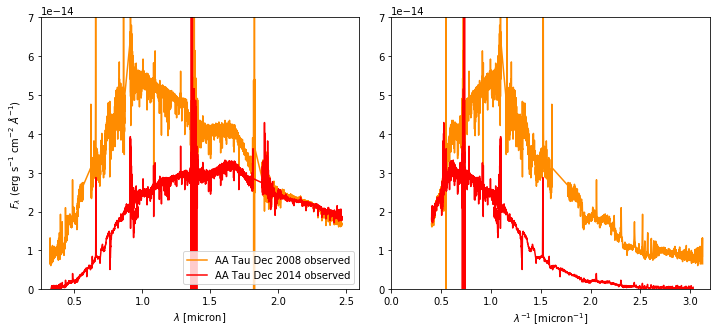

In [44]:
fig,axs=plt.subplots(1,2,figsize=(12,5))

axs[0].plot(allwav_2008,alldata_2008,'darkorange',label='AA Tau Dec 2008 observed')
axs[0].plot(allwav_dec02,alldata_dec02,'red',label='AA Tau Dec 2014 observed')
axs[1].plot(1/allwav_2008,alldata_2008,'darkorange')
axs[1].plot(1/allwav_dec02,alldata_dec02,'red')

axs[0].set_xlim(0.25,2.6)
axs[0].set_ylim(0,0.7E-13)
axs[0].set_ylabel('$F_\lambda$ (erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$)')
axs[0].set_xlabel('$\lambda$ [micron]')
axs[1].set_xlabel('$\lambda^{-1}$ [micron$^{-1}$]')
axs[0].legend(loc='best')
axs[1].set_xlim(0,3.2)
axs[1].set_ylim(0,0.7E-13)
fig.subplots_adjust(wspace=0.1)

plt.show()

In [45]:
# Optional, for when the STScI ftp server is not answering:
config.conf.vega_file='http://ssb.stsci.edu/cdbs/calspec/alpha_lyr_stis_008.fits'
config.conf.johnson_u_file='http://ssb.stsci.edu/cdbs/comp/nonhst/johnson_u_004_syn.fits'
config.conf.johnson_b_file='http://ssb.stsci.edu/cdbs/comp/nonhst/johnson_b_004_syn.fits'
config.conf.johnson_v_file='http://ssb.stsci.edu/cdbs/comp/nonhst/johnson_v_004_syn.fits'
config.conf.johnson_r_file='http://ssb.stsci.edu/cdbs/comp/nonhst/johnson_r_003_syn.fits'
config.conf.johnson_i_file='http://ssb.stsci.edu/cdbs/comp/nonhst/johnson_i_003_syn.fits'
config.conf.bessel_j_file='http://ssb.stsci.edu/cdbs/comp/nonhst/bessell_j_003_syn.fits'
config.conf.bessel_h_file='http://ssb.stsci.edu/cdbs/comp/nonhst/bessell_h_004_syn.fits'
config.conf.bessel_k_file='http://ssb.stsci.edu/cdbs/comp/nonhst/bessell_k_003_syn.fits'

vega = SourceSpectrum.from_vega()
u_band = SpectralElement.from_filter('johnson_u')
b_band = SpectralElement.from_filter('johnson_b')
v_band = SpectralElement.from_filter('johnson_v')
r_band = SpectralElement.from_filter('johnson_r')
i_band = SpectralElement.from_filter('johnson_i')
j_band = SpectralElement.from_filter('bessel_j')
h_band = SpectralElement.from_filter('bessel_h')
k_band = SpectralElement.from_filter('bessel_k')

In [46]:
# The overlaps in the spectra are not tolerated by synphot, so we sort them:
allwav_2008s=allwav_2008[np.argsort(allwav_2008)]
alldata_2008s=alldata_2008[np.argsort(allwav_2008)]

allwav_dec02s=allwav_dec02[np.argsort(allwav_dec02)]
alldata_dec02s=alldata_dec02[np.argsort(allwav_dec02)]

# By coincidence, some wavelengths are identical, so we nudge them a bit:
# WARNING!  HARD WIRED!
allwav_dec02s[2405]=np.float32(0.934964)*u.micron

In [47]:
# Units got screwed up in new version?
# allwav_2008su = allwav_2008s * u.micron
# alldata_2008su = alldata_2008s * u.erg/(u.s*u.cm*u.cm*u.AA)

# allwav_dec02su = allwav_dec02s * u.micron
# alldata_dec02su = alldata_dec02s * u.erg/(u.s*u.cm*u.cm*u.AA)

In [48]:
fobs1ext=dict()

j=0

for A in [2.0,4.0]:
    for R in [2.0,3.0,5.0]:
        ext=F99(Rv=R)
        fobs1ext[j]=alldata_2008s*ext.extinguish(allwav_2008s,Av=A)
        j+=1

In [49]:
bands = [k_band,h_band,j_band,i_band,r_band,v_band,b_band]

mags1ext=np.zeros((6,7))

mags1=np.zeros(7)
mags2=np.zeros(7)
mags3=np.zeros(7)
mags4=np.zeros(7)

for j in [0,1,2,3,4,5,6]:
    sp = SourceSpectrum(Empirical1D, points=allwav_2008s, lookup_table=alldata_2008s, keep_neg=False)
    sp_obs = Observation(sp, bands[j])
    mags1[j]=sp_obs.effstim(flux_unit='vegamag', vegaspec=vega).value # default binned=False
    sp = SourceSpectrum(Empirical1D, points=allwav_dec02s, lookup_table=alldata_dec02s, keep_neg=False)
    sp_obs = Observation(sp, bands[j])
    mags2[j]=sp_obs.effstim(flux_unit='vegamag', vegaspec=vega).value

    sp = SourceSpectrum(Empirical1D, points=allwav_dec02s, lookup_table=alldata_dec02s*10.**(-0.4*(0.02*allwav_dec02s.value**3.0)), keep_neg=False)
    sp_obs = Observation(sp, bands[j])
    mags3[j]=sp_obs.effstim(flux_unit='vegamag', vegaspec=vega).value
    
    
    for i in range(6):
        sp = SourceSpectrum(Empirical1D, points=allwav_2008s, lookup_table=fobs1ext[i], keep_neg=False)
        sp_obs = Observation(sp, bands[j])
        mags1ext[i,j] = sp_obs.effstim(flux_unit='vegamag', vegaspec=vega).value

  points: [13619.504 13621.229 13622.954 13624.678 13807.297 13809.017 13826.228
 13827.947 13924.257 18204.887 18264.535]
  lookup_table: [-0.06155703 -0.16120483 -0.2462627  -0.06569865 -0.03514313 -0.01424272
 -0.01983138 -0.03685726 -0.00325952 -0.02674026 -0.01405363] [synphot.models]
  points: [ 3303.44    3305.8198  3308.2     3312.96    3315.34    3317.72
  3327.24    3334.3801  3336.76    3339.1401  3341.52    3346.2798
  3353.42    3367.7     3370.08    3372.46    3374.84    3377.22
  3386.74    3389.12    3403.4     3405.7798  3408.16    3415.3
  3417.68    3422.44    3424.82    3429.58    3431.96    3450.9998
  3472.42    3515.26    3524.78    3534.3     3643.78    3646.1602
  3648.54   13610.7    13615.8    13617.601  13619.3    13621.
 13622.7    13624.5    13626.2    13645.199  13646.899  13648.601
 13676.2    13677.899  13679.6    13681.399  13683.1    13684.8
 13710.7    13805.4    13807.1    13808.8    13824.3    13825.999
 13827.699  13829.499  13881.101  13924.     

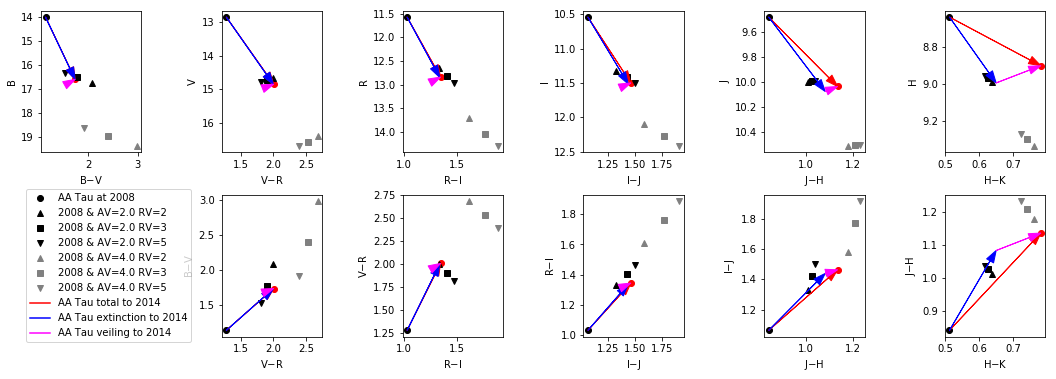

In [50]:
fig,axes=plt.subplots(2,6,figsize=(18,6))

bands=['K','H','J','I','R','V','B']

for j in [0,1,2,3,4,5]: # just data
    if j!=5:
        axes[1,5-j].plot(mags2[j+1]-mags2[j],mags2[j+2]-mags2[j+1],'o',color='red')
        
        axes[1,5-j].annotate("",xy=(mags2[j+1]-mags2[j],mags2[j+2]-mags2[j+1]), xycoords='data',
            xytext=(mags1[j+1]-mags1[j],mags1[j+2]-mags1[j+1]),textcoords='data',alpha=0.5,
            arrowprops=dict(color='red',headwidth=8,headlength=12,width=0.1))

        axes[1,5-j].annotate("",xy=(mags3[j+1]-mags3[j],mags3[j+2]-mags3[j+1]), xycoords='data',
            xytext=(mags1[j+1]-mags1[j],mags1[j+2]-mags1[j+1]),textcoords='data',alpha=0.5,
            arrowprops=dict(color='blue',headwidth=8,headlength=12,width=0.1))

        axes[1,5-j].annotate("",xy=(mags2[j+1]-mags2[j],mags2[j+2]-mags2[j+1]), xycoords='data',
            xytext=(mags3[j+1]-mags3[j],mags3[j+2]-mags3[j+1]),textcoords='data',alpha=0.5,
            arrowprops=dict(color='magenta',headwidth=8,headlength=12,width=0.1))
        
        axes[1,5-j].plot(mags1[j+1]-mags1[j],mags1[j+2]-mags1[j+1],'o',color='black',label='AA Tau at 2008')
        axes[1,5-j].set_xlabel(bands[j+1]+'$-$'+bands[j])
        axes[1,5-j].set_ylabel(bands[j+2]+'$-$'+bands[j+1])
                           
    axes[0,5-j].plot(mags1[j+1]-mags1[j],mags1[j+1],'o',color='black')
    axes[0,5-j].plot(mags2[j+1]-mags2[j],mags2[j+1],'o',color='red')
    axes[0,5-j].annotate("",xy=(mags2[j+1]-mags2[j],mags2[j+1]), xycoords='data',
            xytext=(mags1[j+1]-mags1[j],mags1[j+1]),textcoords='data',alpha=0.5,
            arrowprops=dict(color='red',headwidth=8,headlength=12,width=0.1))

    axes[0,5-j].annotate("",xy=(mags3[j+1]-mags3[j],mags3[j+1]), xycoords='data',
            xytext=(mags1[j+1]-mags1[j],mags1[j+1]),textcoords='data',alpha=0.5,
            arrowprops=dict(color='blue',headwidth=8,headlength=12,width=0.1))
    
    axes[0,5-j].annotate("",xy=(mags2[j+1]-mags2[j],mags2[j+1]), xycoords='data',
            xytext=(mags3[j+1]-mags3[j],mags3[j+1]),textcoords='data',alpha=0.5,
            arrowprops=dict(color='magenta',headwidth=8,headlength=12,width=0.1))
   
    axes[0,5-j].set_xlabel(bands[j+1]+'$-$'+bands[j])
    axes[0,5-j].set_ylabel(bands[j+1])
    
for j in [0,1,2,3,4,5]: # extinction 
    if j!=5:
        axes[1,5-j].plot(mags1ext[0,j+1]-mags1ext[0,j],mags1ext[0,j+2]-mags1ext[0,j+1],'^',color='k',label='2008 & AV=2.0 RV=2')
        axes[1,5-j].plot(mags1ext[1,j+1]-mags1ext[1,j],mags1ext[1,j+2]-mags1ext[1,j+1],'s',color='k',label='2008 & AV=2.0 RV=3')
        axes[1,5-j].plot(mags1ext[2,j+1]-mags1ext[2,j],mags1ext[2,j+2]-mags1ext[2,j+1],'v',color='k',label='2008 & AV=2.0 RV=5')
        axes[1,5-j].plot(mags1ext[3,j+1]-mags1ext[3,j],mags1ext[3,j+2]-mags1ext[3,j+1],'^',color='grey',label='2008 & AV=4.0 RV=2')
        axes[1,5-j].plot(mags1ext[4,j+1]-mags1ext[4,j],mags1ext[4,j+2]-mags1ext[4,j+1],'s',color='grey',label='2008 & AV=4.0 RV=3')
        axes[1,5-j].plot(mags1ext[5,j+1]-mags1ext[5,j],mags1ext[5,j+2]-mags1ext[5,j+1],'v',color='grey',label='2008 & AV=4.0 RV=5')

    axes[0,5-j].plot(mags1ext[0,j+1]-mags1ext[0,j],mags1ext[0,j+1],'^',color='k')
    axes[0,5-j].plot(mags1ext[1,j+1]-mags1ext[1,j],mags1ext[1,j+1],'s',color='k')
    axes[0,5-j].plot(mags1ext[2,j+1]-mags1ext[2,j],mags1ext[2,j+1],'v',color='k')
    axes[0,5-j].plot(mags1ext[3,j+1]-mags1ext[3,j],mags1ext[3,j+1],'^',color='grey')
    axes[0,5-j].plot(mags1ext[4,j+1]-mags1ext[4,j],mags1ext[4,j+1],'s',color='grey')
    axes[0,5-j].plot(mags1ext[5,j+1]-mags1ext[5,j],mags1ext[5,j+1],'v',color='grey')
    
# axes[1,1].plot(mags2[5]-mags2[4],mags2[6]-mags2[5],'o',color='red',label='AA Tau 2014') # just for the legend
axes[1,1].plot([],'red',label='AA Tau total to 2014')
axes[1,1].plot([],'blue',label='AA Tau extinction to 2014')
axes[1,1].plot([],'magenta',label='AA Tau veiling to 2014')
axes[1,0].axis('off')
fig.subplots_adjust(wspace=0.8,hspace=0.3)
axes[1,1].legend(loc='center left', bbox_to_anchor=(-2, 0.5))
for j in [0,1,2,3,4,5]:
    axes[0,5-j].set_ylim(axes[0,5-j].get_ylim()[::-1])

plt.show()

(0, 7e-14)

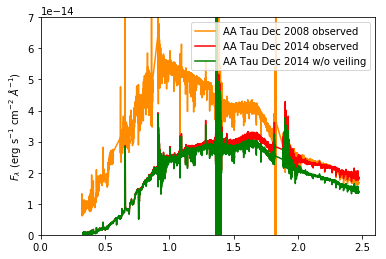

In [51]:
ext=F99(Rv=3)
fext=alldata_dec02s*10.**(-0.4*2.*ext(allwav_dec02s))
fveil=alldata_dec02s*10.**(-0.4*(0.02*allwav_dec02s.value**3.0))

fig,ax=plt.subplots(1,1)
ax.plot(allwav_2008,alldata_2008,'darkorange',label='AA Tau Dec 2008 observed')
ax.plot(allwav_dec02,alldata_dec02,'red',label='AA Tau Dec 2014 observed')
ax.plot(allwav_dec02s,fveil,'green',label='AA Tau Dec 2014 w/o veiling')

ax.set_xlim(0.25,2.6)
ax.set_ylim(0,0.7E-13)
ax.set_ylabel('$F_\lambda$ (erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$)')
ax.legend(loc='best')
ax.set_xlim(0,2.6)
ax.set_ylim(0,0.7E-13)